> To add this to the repo, all I did was download the [original repo](https://github.com/andreybicalho/ExtendedMorphologicalProfiles) as a zip file, upload the zip into the codespace and unzip it (`unzip ExtendedMorphologicalProfiles-master.zip`). This notebook runs without errors in Codespaces.


# Remote Sensed Hyperspectral Image Classification With The Extended Morphological Profiles and Support Vector Machines

This is an example of how to use the Extended Morphological Profiles and Support Vector Machines to classify remote sensed hyperspectral images using Python.

# The Indian Pines Dataset
Our dataset is gathered by the Airborne Visible/Infrared Imaging Spectrometer (AVIRIS) hyperspectral sensor data. Indian Pines dataset was recorded over Northwestern Indiana, USA, and consists of 145x145 pixels and 224 spectral bands/channels in the wavelength range 0.4–2.5 10^(-6) meters. This AVIRIS image file represents a 2 mile by 2 mile area at 20 meters spatial resolution. Indian Pines data are available through [Pursue's univeristy MultiSpec site](https://engineering.purdue.edu/~biehl/MultiSpec/hyperspectral.html). A Matlab version is also available in [here](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) where the most noisy bands ([104-108], [150-163], 220) were removed, leaving a total of 200 bands to work with. The Indian Pines scene contains two-thirds agriculture, and one-third forest or other natural perennial vegetation. There are two major dual lane highways, a rail line, as well as some low density housing, other built structures, and smaller roads. The ground truth available is designated into sixteen classes (seventeen if you consider the background) and is not all mutually exclusive.

Let's import the dataset and groundtruth:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

dataset = io.loadmat('indianpines_dataset.mat')
number_of_bands = int(dataset['number_of_bands'])
number_of_rows = int(dataset['number_of_rows'])
number_of_columns = int(dataset['number_of_columns'])
pixels = np.transpose(dataset['pixels'])

groundtruth = io.loadmat('indianpines_gt.mat')
gt = np.transpose(groundtruth['pixels'])

/tmp/ipykernel_3019/3453589288.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_of_bands = int(dataset['number_of_bands'])
/tmp/ipykernel_3019/3453589288.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_of_rows = int(dataset['number_of_rows'])
/tmp/ipykernel_3019/3453589288.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_of_columns = int(dataset['number_of_columns'])


Let's create our hypercube in order to visualize the scene and the categories that are presents. The image shows a RGB false color composition in which we used bands 29, 42 and 89, respectively.

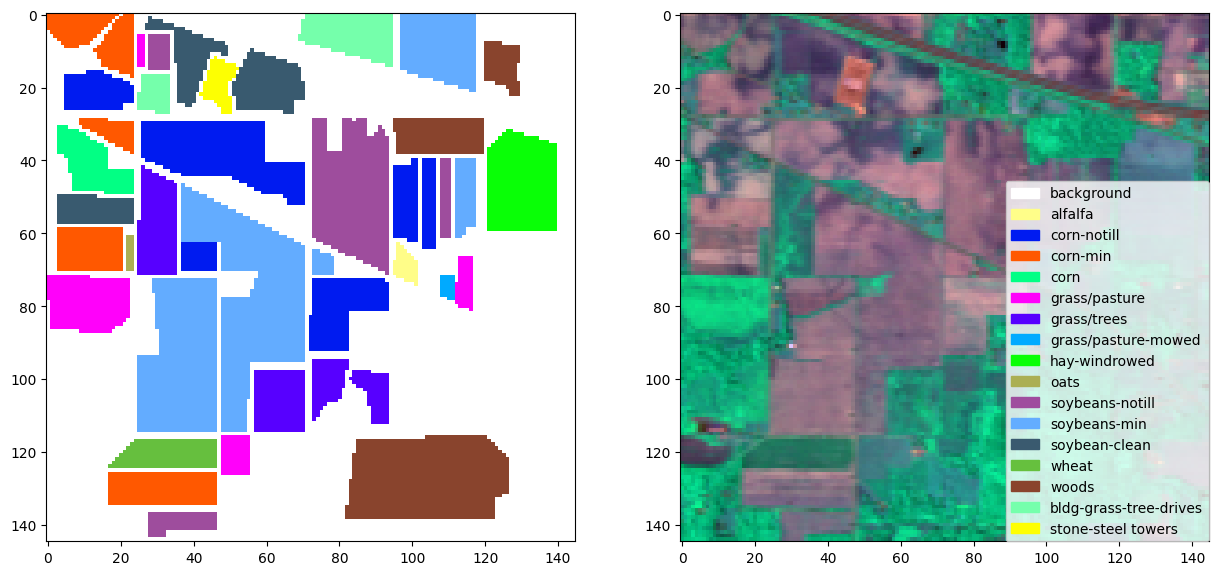

In [2]:
# normalizing the dataset (standard procedure)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
pixels = sc.fit_transform(pixels)

# colors for each category in the dataset
indianpines_colors = np.array([[255, 255, 255],
                               [255, 254, 137], [3,  28,  241], [255, 89,    1], [5,   255, 133],
                               [255,   2, 251], [89,  1,  255], [3,   171, 255], [12,  255,   7],
                               [172, 175,  84], [160, 78, 158], [101, 173, 255], [60,   91, 112],
                               [104, 192,  63], [139, 69,  46], [119, 255, 172], [254, 255,   3]])

# normalize in the range of 0 and 1 for displaying
import sklearn.preprocessing
indianpines_colors = sklearn.preprocessing.minmax_scale(indianpines_colors, feature_range=(0, 1))
pixels_normalized = sklearn.preprocessing.minmax_scale(pixels, feature_range=(0, 1))

# build the RGB Image
gt_thematic_map = np.zeros(shape=(number_of_rows, number_of_columns, 3))
rgb_hyperspectral_image = np.zeros(shape=(number_of_rows, number_of_columns, 3))
cont = 0
for i in range(number_of_rows):
    for j in range(number_of_columns):
        rgb_hyperspectral_image[i, j, 0] = pixels_normalized[cont, 29]
        rgb_hyperspectral_image[i, j, 1] = pixels_normalized[cont, 42]
        rgb_hyperspectral_image[i, j, 2] = pixels_normalized[cont, 89]
        gt_thematic_map[i, j, :] = indianpines_colors[gt[cont, 0]]
        cont += 1

# names of the categories in the dataset
indianpines_class_names = ['background',
                           'alfalfa',           'corn-notill',               'corn-min',               'corn',
                           'grass/pasture',     'grass/trees',    'grass/pasture-mowed',      'hay-windrowed',
                           'oats',          'soybeans-notill',           'soybeans-min',      'soybean-clean',
                           'wheat',                   'woods', 'bldg-grass-tree-drives', 'stone-steel towers']

fig = plt.figure(figsize=(15, 15))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(gt_thematic_map)
fig.add_subplot(rows, columns, 2)
plt.imshow(rgb_hyperspectral_image)

import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=indianpines_colors[i], label=indianpines_class_names[i]) for i in range(len(indianpines_colors))]
plt.legend(handles=patches, loc=4, borderaxespad=0.)
plt.show()

# Principal Component Analysis (PCA)

We won't build the a Morphological Profile (MP) for each band in the dataset otherwise it would lead to a huge amount of features, instead, we will apply the Principal Components Analysis (PCA) to reduce the amount of bands in the hypercube and use the Principal Components (PC) that give us at least 96% of the total explained variance in the data to use as our main set of features.

In [3]:
from sklearn.decomposition import PCA
number_of_pc = 4
pca = PCA(n_components=number_of_pc)
pc = pca.fit_transform(pixels)

print(f"The accumulated explained variance for the {number_of_pc} principal components is {np.sum(pca.explained_variance_ratio_)}")
print(f"Individual Explained Variance: {pca.explained_variance_ratio_}")

The accumulated explained variance for the 4 principal components is 0.9640597426989977
Individual Explained Variance: [0.69811201 0.22877679 0.02256244 0.01460851]


Let's inspect each individual PC by visualizing it in the gray color space:

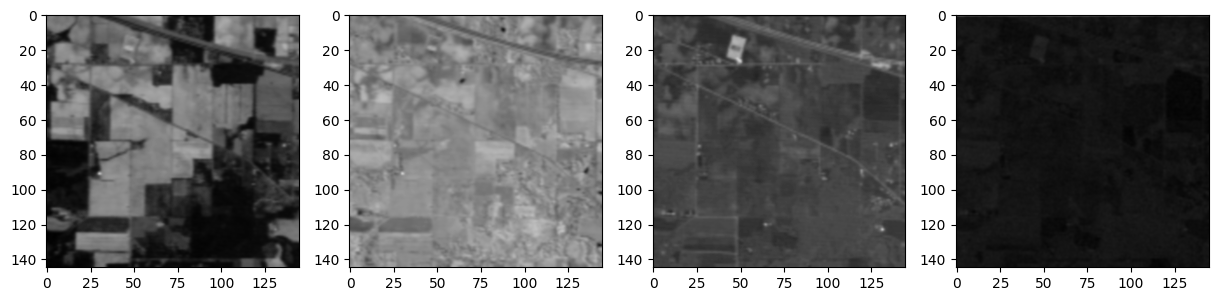

In [4]:
fig = plt.figure(figsize=(15, 15))
columns = number_of_pc
rows = 1
pc_images = np.zeros(shape=(number_of_rows, number_of_columns, number_of_pc))
for i in range(number_of_pc):
    pc_images[:, :, i] = np.reshape(pc[:, i], (number_of_rows, number_of_columns))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(pc_images[:, :, i], cmap='gray', interpolation='bicubic')

plt.show()

We can see that by using only 4 components we were able to capture most of the main visual information present in the whole hypercube. Hence, we will use these 4 images as our main set of features to apply the EMP method. Note that in this stage of the pipeline we can use whatever feature extraction method we like... ;D

# Extended Morphological Profiles (EMP)

The Extended Morphological Profiles (EMP) is based on the mathematical morphology operators known as opening and closing.
Briefly, opening and closing transformations can isolate bright (opening) and dark (closing) structures in images. Opening removes small objects from the foreground (usually taken as the bright pixels) of an image, placing them in the background, while closing removes small holes in the foreground, changing small islands of background into foreground. Reconstruction method is able to restore the objects completely after applying the underlying operations (erosion/dilation) from the opening/closing.

Each Morphological Profile (MP) enlarges or reduces dark and bright structures using openings and closings by reconstruction, resulting in a more homogeneous version of the original image. At each iteration, the Structuring Element (SE) is increased to capture further spatial information.

In [5]:
# Opening and Closing by Reconstruction
from skimage.morphology import reconstruction
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage import util

def opening_by_reconstruction(image, se):
    """
        Performs an Opening by Reconstruction.

        Parameters:
            image: 2D matrix.
            se: structuring element
        Returns:
            2D matrix of the reconstructed image.
    """
    eroded = erosion(image, se)
    reconstructed = reconstruction(eroded, image)
    return reconstructed


def closing_by_reconstruction(image, se):
    """
        Performs a Closing by Reconstruction.

        Parameters:
            image: 2D matrix.
            se: structuring element
        Returns:
            2D matrix of the reconstructed image.
    """
    obr = opening_by_reconstruction(image, se)

    obr_inverted = util.invert(obr)
    obr_inverted_eroded = erosion(obr_inverted, se)
    obr_inverted_eroded_rec = reconstruction(
        obr_inverted_eroded, obr_inverted)
    obr_inverted_eroded_rec_inverted = util.invert(obr_inverted_eroded_rec)
    return obr_inverted_eroded_rec_inverted

In our tests we will use a structuring element with disk shape of 4 pixels size (diameter), an increment step of 2 pixels and 4 openings and closings. The number of features of each MP is $2n+1$, $n$ being the number of openings/closings. The total number of features in the EMP is $(2n+1) * p$, where $p$ is number of principal components used to build the EMP.

In [6]:
def build_morphological_profiles(image, se_size=4, se_size_increment=2, num_openings_closings=4):
    """
        Build the morphological profiles for a given image.

        Parameters:
            base_image: 2d matrix, it is the spectral information part of the MP.
            se_size: int, initial size of the structuring element (or kernel). Structuring Element used: disk
            se_size_increment: int, structuring element increment step
            num_openings_closings: int, number of openings and closings by reconstruction to perform.
        Returns: 
            emp: 3d matrix with both spectral (from the base_image) and spatial information         
    """
    x, y = image.shape

    cbr = np.zeros(shape=(x, y, num_openings_closings))
    obr = np.zeros(shape=(x, y, num_openings_closings))

    it = 0
    tam = se_size
    while it < num_openings_closings:
        se = disk(tam)
        temp = closing_by_reconstruction(image, se)
        cbr[:, :, it] = temp[:, :]
        temp = opening_by_reconstruction(image, se)
        obr[:, :, it] = temp[:, :]
        tam += se_size_increment
        it += 1

    mp = np.zeros(shape=(x, y, (num_openings_closings*2)+1))
    cont = num_openings_closings - 1
    for i in range(num_openings_closings):
        mp[:, :, i] = cbr[:, :, cont]
        cont = cont - 1

    mp[:, :, num_openings_closings] = image[:, :]

    cont = 0
    for i in range(num_openings_closings+1, num_openings_closings*2+1):
        mp[:, :, i] = obr[:, :, cont]
        cont += 1

    return mp


def build_emp(base_image, se_size=4, se_size_increment=2, num_openings_closings=4):
    """
        Build the extended morphological profiles for a given set of images.

        Parameters:
            base_image: 3d matrix, each 'channel' is considered for applying the morphological profile. It is the spectral information part of the EMP.
            se_size: int, initial size of the structuring element (or kernel). Structuring Element used: disk
            se_size_increment: int, structuring element increment step
            num_openings_closings: int, number of openings and closings by reconstruction to perform.
        Returns:
            emp: 3d matrix with both spectral (from the base_image) and spatial information
    """
    base_image_rows, base_image_columns, base_image_channels = base_image.shape
    se_size = se_size
    se_size_increment = se_size_increment
    num_openings_closings = num_openings_closings
    morphological_profile_size = (num_openings_closings * 2) + 1
    emp_size = morphological_profile_size * base_image_channels
    emp = np.zeros(
        shape=(base_image_rows, base_image_columns, emp_size))

    cont = 0
    for i in range(base_image_channels):
        # build MPs
        mp_temp = build_morphological_profiles(
            base_image[:, :, i], se_size, se_size_increment, num_openings_closings)

        aux = morphological_profile_size * (i+1)

        # build the EMP
        cont_aux = 0
        for k in range(cont, aux):
            emp[:, :, k] = mp_temp[:, :, cont_aux]
            cont_aux += 1

        cont = morphological_profile_size * (i+1)

    return emp

pc_images.shape
num_openings_closings = 4
morphological_profile_size = (num_openings_closings * 2) + 1
emp_image = build_emp(base_image=pc_images, num_openings_closings=num_openings_closings)

With 4 PC, 4 openings/closings with a increasing step of 2 we will have 36 features in the EMP.

Let's inspect the EMP by visualizing its features in the gray color space:

Number of Base Images: 4
Morphological Profiles size: 9
EMP:  (145, 145, 36)


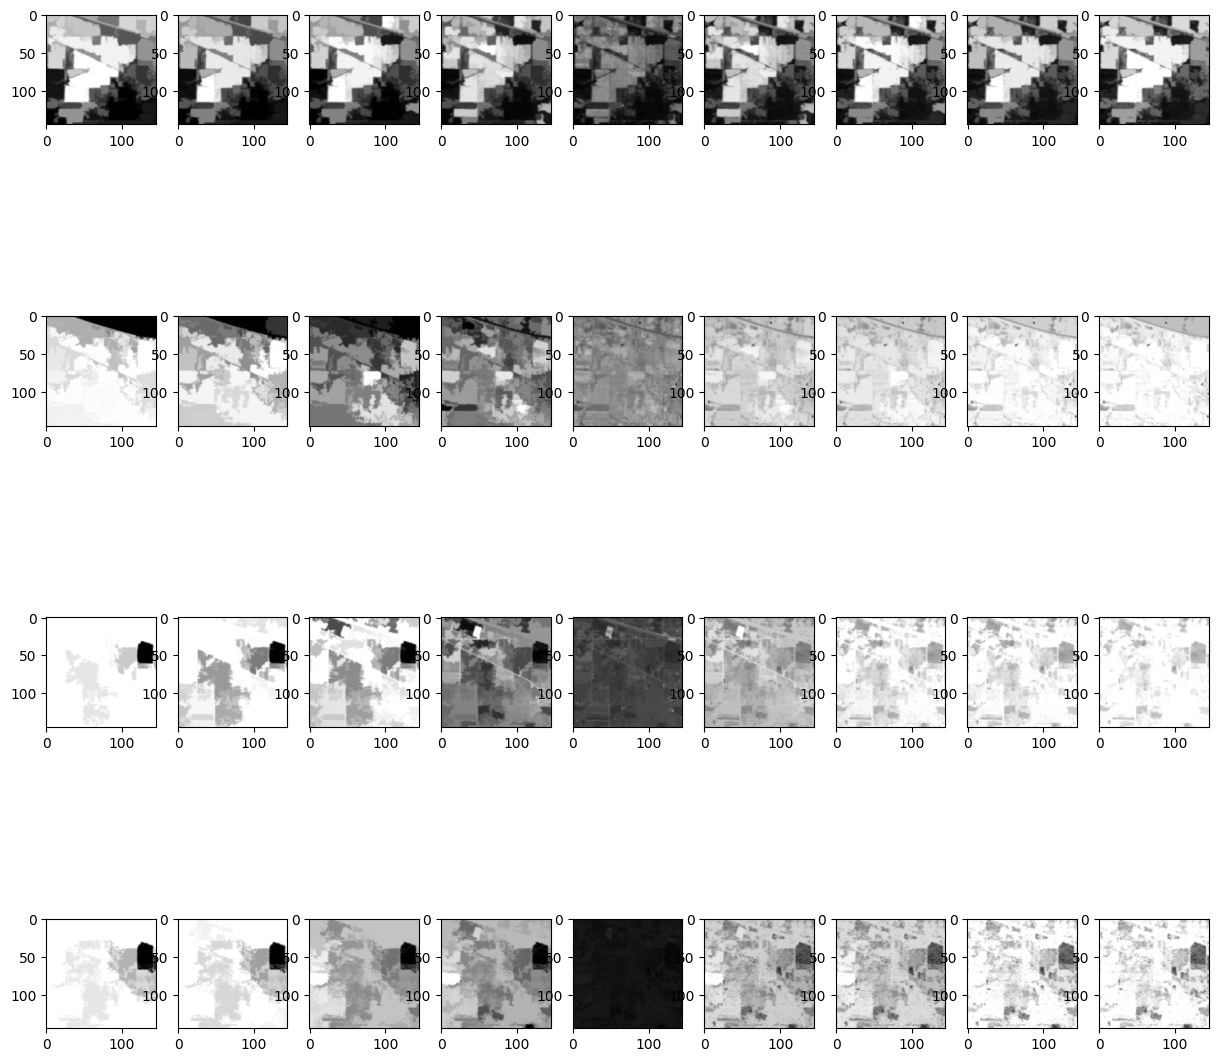

In [7]:
fig = plt.figure(figsize=(15, 15))
columns = morphological_profile_size
rows = number_of_pc
print("Number of Base Images: "+str(rows))
print("Morphological Profiles size: "+str(columns))
print("EMP:  "+str(emp_image.shape))

emp_size = morphological_profile_size * number_of_pc
for i in range(1, emp_size+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(emp_image[:, :, i-1], cmap='gray', interpolation='bicubic')

plt.show()

# Classification: Support Vector Machines (SVM)

Now that we have built this new set of features with the EMP approach, let's now built a classification model to assign every pixel in this EMP image into some of the our known 17 categories. For this purpose we will use the Support Vector Machines (SVM) learning algorithm with the Radial Basis Function (RBF) kernel. In this stage of the pipeline you can assume that it can be used whatever machine learning algorithm on earth, right?! So, why SVM? It has shown in the literacture that SVMs have reasonable accuracy even with low training sets which is great for our problem since our dataset have only a few samples for some categories. We'll split our dataset into training and testing sets with size of 25% and 75%, respectively.

In [8]:
dim_x, dim_y, dim_z = emp_image.shape
dim = dim_x * dim_y

x = np.zeros(shape=(dim, dim_z))
y = gt

cont = 0
for i in range(dim_x):
    for j in range(dim_y):
        x[cont, :] = emp_image[i, j, :]
        cont += 1

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.75, random_state=0)

# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Visualizing The Results

In order to verify the accuracy of our SVM model and check the results for each category in the dataset let's plot a confusion matrix:

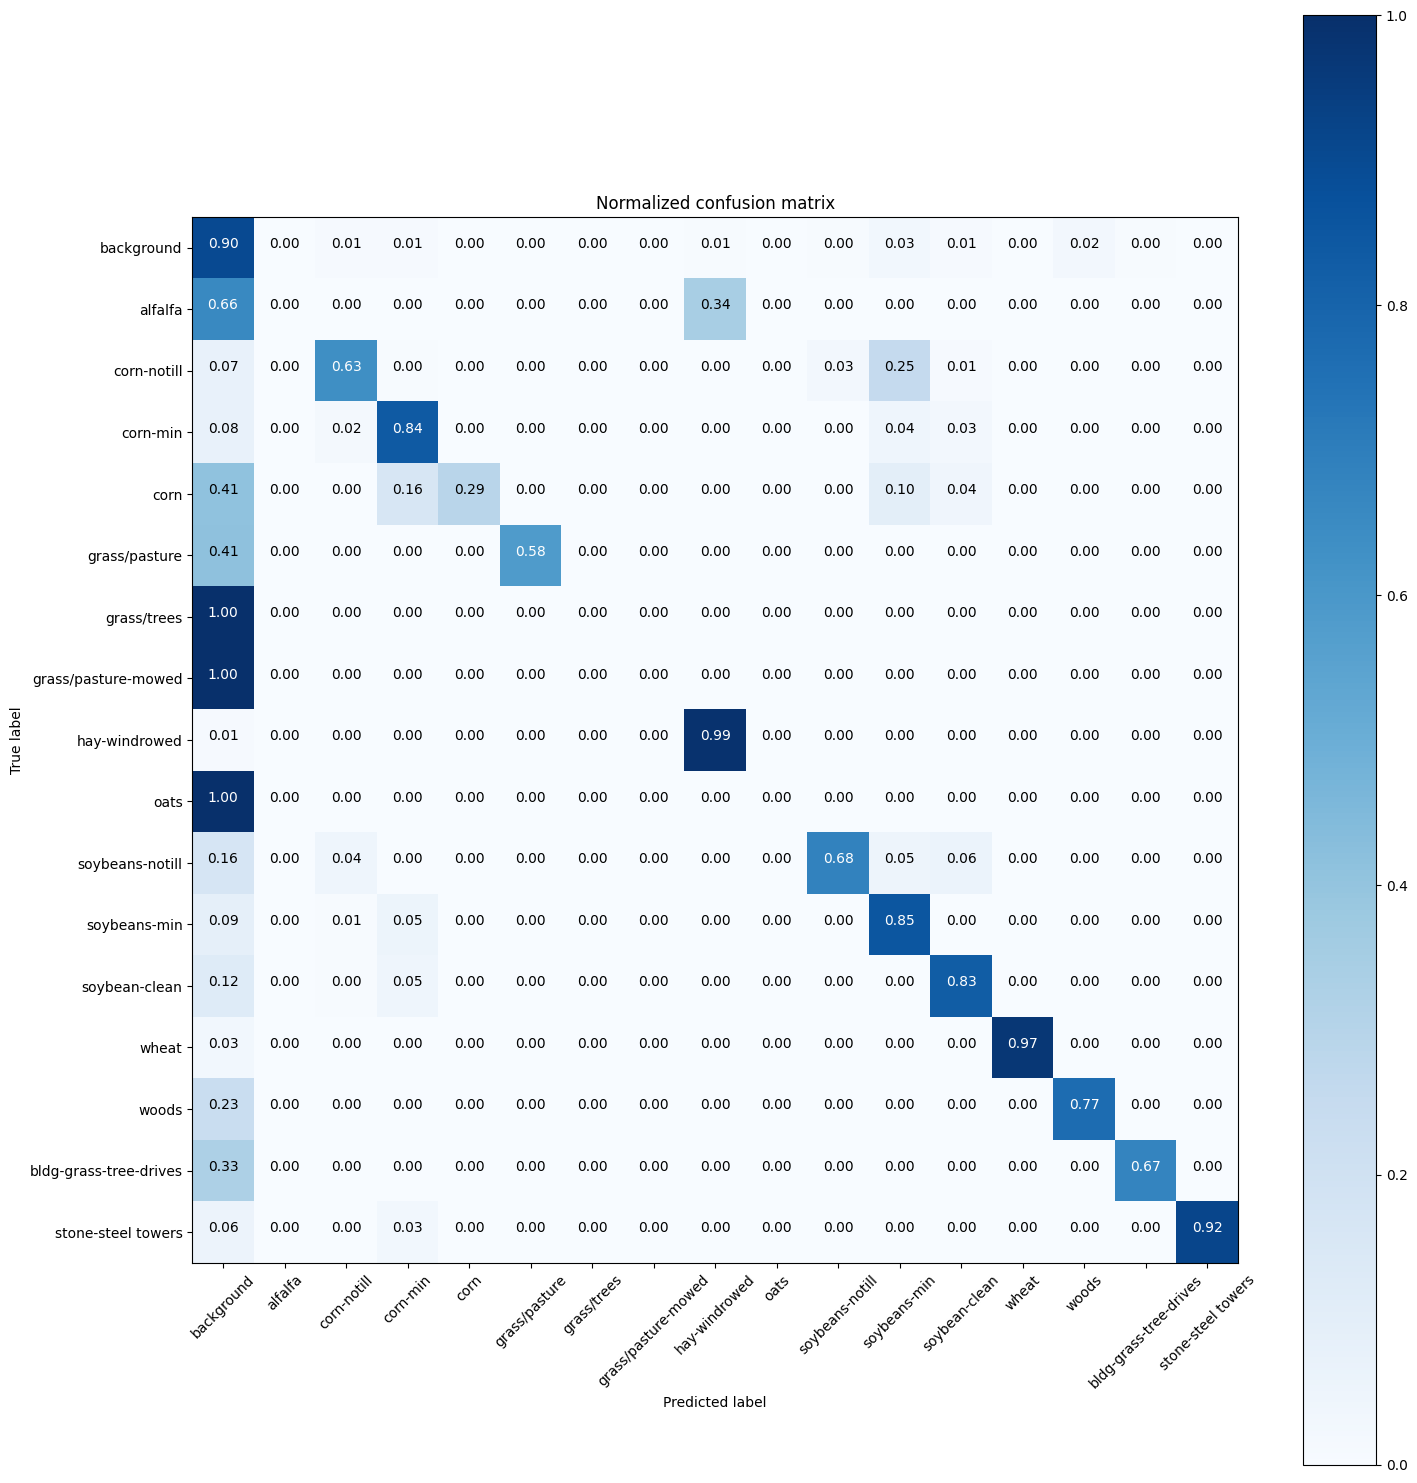

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the results
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm, classes=indianpines_class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Let's build a thematic map in order to visually inspect our results:

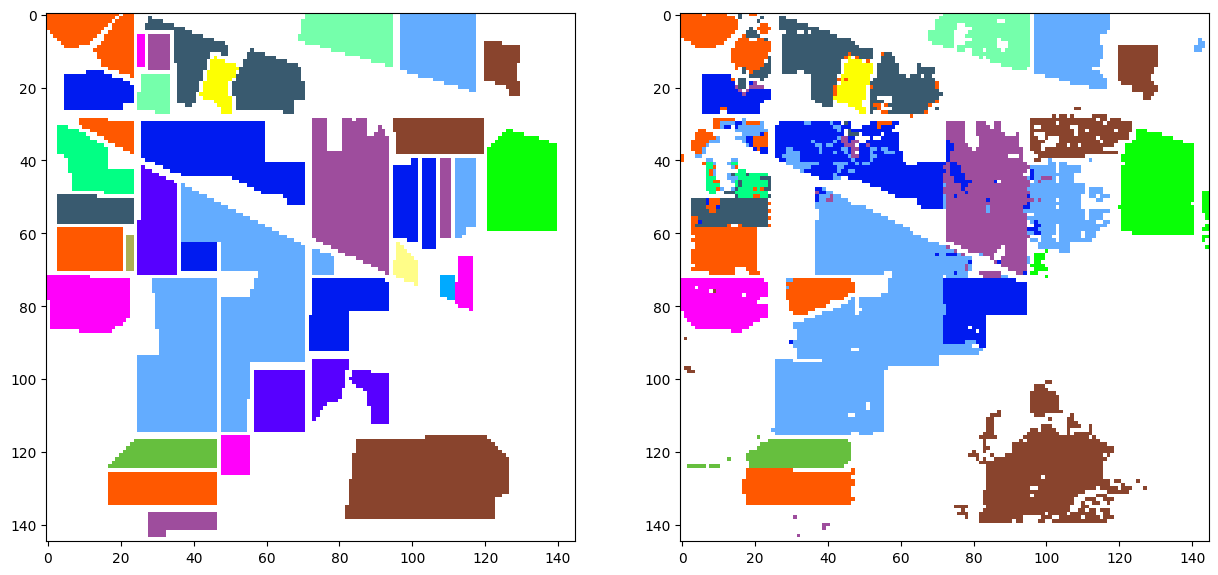

In [10]:
predicted_thematic_map = np.zeros(shape=(number_of_rows, number_of_columns, 3))
predicted_dataset = classifier.predict(x)

cont = 0
for i in range(number_of_rows):
    for j in range(number_of_columns):
        gt_thematic_map[i, j, :] = indianpines_colors[gt[cont, 0]]
        predicted_thematic_map[i, j, :] = indianpines_colors[predicted_dataset[cont]]
        cont += 1

fig = plt.figure(figsize=(15, 15))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(gt_thematic_map)
fig.add_subplot(rows, columns, 2)
plt.imshow(predicted_thematic_map)
plt.show()

# References

Please consider the following papers for further reading:

[J.A. Benediktsson, J.A. Palmason, and J.R. Sveinsson, “Classification of hyperspectral data from urban areas based on extended morphological profiles,” IEEE Trans. on Geoscience and Remote Sensing, vol. 43, no. 3, pp. 480–491, 2005.](https://doi.org/10.1109/TGRS.2004.842478)

[SANTOS, ANDREY BICALHO; DE ALBUQUERQUE ARAUJO, ARNALDO ; SCHWARTZ, WILLIAM ROBSON ; MENOTTI, DAVID . Hyperspectral image interpretation based on partial least squares. In: 2015 IEEE International Conference on Image Processing (ICIP), 2015, Quebec City. 2015 IEEE International Conference on Image Processing (ICIP), 2015. p. 1885-1889.](https://doi.org/10.1109/ICIP.2015.7351128)